# Spam Classifier

## Requirements
If you are running this in colab you will need to download the trec07p email database and also 4 text files which define the training and testing sets and their labels. The cells below will download the files from your google drive if they are in a folder called 'spamdata'.  The 4 text files are:

* train_set.txt
* train_label.txt
* test_set.txt
* test_label.txt

The database is called trec07p.tgz and can be downloaded from:

https://plg.uwaterloo.ca/cgi-bin/cgiwrap/gvcormac/trec07p.tgz

If you are running this locally the text files should be in the same folder as the python notebook and the trec07p folder should be in a folder called 'Emails'.

## Reference
Using sections of code from Sijoon Lee, 2019, https://github.com/sijoonlee/spam-ham-walkthrough


In [0]:
from google.colab import drive
drive.mount('/content/drive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/drive


In [0]:
! cp /content/drive/My\ Drive/spamdata/trec07p.tgz ./ 
! tar xvf trec07p.tgz >/dev/null
! mkdir Emails
! mv trec07p Emails/
! cp /content/drive/My\ Drive/spamdata/*.txt ./


##  Run Options

The model has 4 modes:

* Use subject only
* Use body only
* Use body+subject as one sequence
* Use body and subject as separate sequences

The mode to use can be selected by setting the variable run-selected, e.g.

```
run_selected = model_type.duallstm
```

In [0]:
import os
import sys
import pandas as pd
import numpy as np
import re
from time import time
from enum import Enum

class model_type(Enum):
    subject = 1
    body = 2
    combined = 3
    duallstm = 4
    
# Select the model to run
run_selected = model_type.duallstm

# Maximum body size.  There are a few outlier very long e-mails which
# will cause the training to exceed the memory of the CPU or GPU
truncate_body = 5000

# Location of the raw dataset
email_folder = os.path.join("Emails", "trec07p")


## Parsing Emails

The function parse_email takes a filename and returns a list of the words in the subject and a list of the words in the body.

If the body is base64 encoded it will be decoded and it it is HTML it will be converted to plain text. If there are multiple text and html parts to the body they will be concatenated, although trucated to the value of the truncate_body variable.

In [0]:
import email
import base64
from email.parser import Parser
from bs4 import BeautifulSoup

# Convert HTML body to plain text
def extract_html(html_content):
    soup = BeautifulSoup(html_content, 'html.parser')
    text = soup.find_all(text=True)

    output = ''
    blacklist = [
    '[document]',
    'noscript',
    'header',
    'html',
    'meta',
    'head', 
    'input',
    'script',
    'style',
    ]

    for t in text:
        if t.parent.name not in blacklist:
            output += '{} '.format(t)
            
    return(output)

# Generate a body by combining all parts of the email
def walk_email(msg):
    body = ''
    
    for part in msg.walk():
        if part.get_content_type() == 'text/plain':
            body = body + part.get_payload()
        elif part.get_content_type() == 'text/html':
# If the body is base64 encoded decode it
            if part.get('Content-Transfer-Encoding') == 'base64':
                body = body + extract_html(base64.b64decode(part.get_payload()))     
            else:
                body = body + extract_html(part.get_payload())
                
        body_words = body.lower().split()
        if len(body_words) > truncate_body:
            body_words= body_words[:truncate_body]
            
    return body_words

# Process a single email by splitting it into lists of the words in the subject and body
def parse_email(filename):
    parser = Parser()
    with open(filename, encoding='utf-8', errors='replace') as f:
        text = f.read()
        email = parser.parsestr(text)
        subject = email.get('Subject')

        body_words = walk_email(email)
        
        if subject is None:
            subject = ''
        subject_words = subject.lower().split()
        if len(body_words) == 0:
            body_words = text.lower().split()
            if len(body_words) > truncate_body:
                body_words= body_words[:truncate_body]
    f.closed
    return (subject_words, body_words)

## Read Datasets

To ensure the same datasets are used for training and testing the sets are read in from text files.  These should be created in advance and in the same folder as the notebook.

The training dataset is further split into a training (70%) and validation (30%) dataset for training the network.

In [0]:


print("Reading datasets from file:")
f_train = open("train_set.txt","r")
f_train_label = open("train_label.txt","r")
f_test = open("test_set.txt","r")
f_test_label = open("test_label.txt","r")

x_train_full = np.loadtxt(f_train,dtype=str,delimiter='\n')
y_train_full = np.loadtxt(f_train_label,dtype=int,delimiter='\n')
x_test = np.loadtxt(f_test,dtype=str,delimiter='\n')
y_test = np.loadtxt(f_test_label,dtype=int,delimiter='\n')

f_train.close()
f_train_label.close()
f_test.close()
f_test_label.close()

train_split = 0.7
length = len(y_train_full)
length_train = int(length*train_split)
length_valid = length - length_train

x_train = x_train_full[:length_train]
y_train = y_train_full[:length_train]
x_valid = x_train_full[length_train:]
y_valid = y_train_full[length_train:]

print("Number of emails in training set: %s" % len(x_train))
print("Number of emails in validation set: %s" % len(x_valid))
print("Number of emails in test set: %s" % len(x_test))

Reading datasets from file:
Number of emails in training set: 13125
Number of emails in validation set: 5625
Number of emails in test set: 6250


## Build a dictionary

Before parsing the emails a dictionary of all the words which occur in the emails is needed.  The first time this notebook is run the entire training set of emails will be read and parsed in order to create the dictionary. Words which occur in fewer than 5 emails will not be included to reduce the size of the dictionary and therefore reduce memory usage.

As this is a time consuming process, the dictionary will be saved and used for future runs.


In [0]:
import pickle
from collections import Counter

cnt = Counter([])

if os.path.isfile("vocab.dict"):
    print("Loading vocab from file...")
    vocab_to_int = pickle.load( open( "vocab.dict", "rb" ) )
else:
    print("Generating new vocab from email training set...")
    processed = 0
    for i in range(len(x_train_full)):
        m = os.path.join(email_folder, "data", "inmail."+str(x_train_full[i]))

        processed = processed + 1
        if processed % 500 == 0:
            print("Building Vocab: %d" % processed)
        email_file = m
        
        subject_words, body_words = parse_email(email_file)

        cnt.update([vocab for vocab in list(dict.fromkeys(subject_words))]) # Remove duplicates so we only count the number of mails with each word
        cnt.update([vocab for vocab in list(dict.fromkeys(body_words))])
        
    vocab_count = cnt.most_common(len(cnt))
    vocab_to_int = {word : index+2 for index, (word, count) in enumerate(vocab_count) if count > 5} 
    vocab_to_int.update({'__PADDING__': 0}) # index 0 for padding
    vocab_to_int.update({'__UNKNOWN__': 1}) # index 1 for unknown word such as broken character
    pickle.dump( vocab_to_int, open( "vocab.dict", "wb" ) )
    
print({k: vocab_to_int[k] for k in list(vocab_to_int.keys())[:20]})
print("Number of words in vocab: %s" % len(vocab_to_int))

Generating new vocab from email training set...
Building Vocab: 500
Building Vocab: 1000
Building Vocab: 1500
Building Vocab: 2000
Building Vocab: 2500
Building Vocab: 3000
Building Vocab: 3500
Building Vocab: 4000
Building Vocab: 4500
Building Vocab: 5000
Building Vocab: 5500
Building Vocab: 6000
Building Vocab: 6500
Building Vocab: 7000
Building Vocab: 7500
Building Vocab: 8000
Building Vocab: 8500
Building Vocab: 9000
Building Vocab: 9500
Building Vocab: 10000
Building Vocab: 10500
Building Vocab: 11000
Building Vocab: 11500
Building Vocab: 12000
Building Vocab: 12500
Building Vocab: 13000
Building Vocab: 13500
Building Vocab: 14000
Building Vocab: 14500
Building Vocab: 15000
Building Vocab: 15500
Building Vocab: 16000
Building Vocab: 16500
Building Vocab: 17000
Building Vocab: 17500
Building Vocab: 18000
Building Vocab: 18500
{'the': 2, 'to': 3, 'a': 4, 'and': 5, 'for': 6, 'in': 7, 'of': 8, 'you': 9, 'is': 10, 'with': 11, 'your': 12, 'on': 13, 'this': 14, 'that': 15, 'be': 16, 'are

## Read all emails in dataset

Read in all the emails and return a Pandas datafrom containing the tokenised and vectorised subject and body and the spam/ham label

In [0]:
def parse_emails(x,y):

    returned_mail = pd.DataFrame(columns=["spam", "subject", "body"])
    processed = 0
    max_subject_length = 0
    max_body_length = 0
    
#     x=x[:2000]
    
    for i in range(len(x)):
        m = os.path.join(email_folder, "data", "inmail."+str(x[i]))
        l = y[i]

        processed = processed + 1
        if processed % 500 == 0:
            print("Parsing emails: %d" % processed)
        spam = l
        email_file = m
        
        subject_words, body_words = parse_email(email_file)

        subject_vectors = [ vocab_to_int.get(word, 1) for word in subject_words]
        if len(subject_vectors) > max_subject_length:
            max_subject_length = len(subject_vectors)

        body_vectors = [ vocab_to_int.get(word, 1) for word in body_words]

        if (run_selected == model_type.combined):
            body_vectors = body_vectors + subject_vectors

        if len(body_vectors) > max_body_length:
            max_body_length = len(body_vectors)

        if len(body_vectors) == 0:
            body_vectors = [1]
        if len(subject_vectors) == 0:
            subject_vectors = [1]
        returned_mail = returned_mail.append(pd.DataFrame({"spam": spam, "subject": [subject_vectors], "body": [body_vectors]}), ignore_index = True)

    return (returned_mail, max_subject_length, max_body_length)



## Create a Custom Data Loader

The dataloader takes the dataset and returns an iterator which can be used to read the dataset in batches

In [0]:
import torch.utils.data.sampler as splr

class CustomDataLoader(object):
  def __init__(self, seq_tensor, seq_lengths, body_seq_tensor, body_seq_lengths, label_tensor, batch_size):
    self.batch_size = batch_size
    self.seq_tensor = seq_tensor
    self.seq_lengths = seq_lengths
    self.body_seq_tensor = body_seq_tensor
    self.body_seq_lengths = body_seq_lengths
    self.label_tensor = label_tensor
    self.sampler = splr.BatchSampler(splr.RandomSampler(self.label_tensor), self.batch_size, False)
    self.sampler_iter = iter(self.sampler)
    
  def __iter__(self):
    self.sampler_iter = iter(self.sampler) # reset sampler iterator
    return self

  def _next_index(self):
    return next(self.sampler_iter) # may raise StopIteration

  def __next__(self):
    index = self._next_index()

    subset_seq_tensor = self.seq_tensor[index].to(device)
    subset_seq_lengths = self.seq_lengths[index].to(device)
    subset_body_seq_tensor = self.body_seq_tensor[index].to(device)
    subset_body_seq_lengths = self.body_seq_lengths[index].to(device)
    subset_label_tensor = self.label_tensor[index].to(device)

    return subset_seq_tensor, subset_seq_lengths, subset_body_seq_tensor, subset_body_seq_lengths, subset_label_tensor

  def __len__(self):
    return len(self.sampler)

## Generate loaders for each of the datasets

In [0]:
import torch
from torch.autograd import Variable


def process_dataset(x,y):
    parsed_train, max_subject_length, max_body_length = parse_emails(x,y)
    
    label_tensor = torch.as_tensor(parsed_train["spam"], dtype = torch.int16)
    subject_vectorized_seqs = parsed_train["subject"]
    body_vectorized_seqs = parsed_train["body"]

    subject_seq_lengths = torch.LongTensor(list(map(len, subject_vectorized_seqs)))
    body_seq_lengths = torch.LongTensor(list(map(len, body_vectorized_seqs)))

# Pad the sequences because they all need to be the same length
    subject_seq_tensor = Variable(torch.zeros((len(subject_vectorized_seqs), max_subject_length))).long()
    body_seq_tensor = Variable(torch.zeros((len(body_vectorized_seqs), max_body_length))).long()

    for idx, (seq, seqlen) in enumerate(zip(subject_vectorized_seqs, subject_seq_lengths)):
      subject_seq_tensor[idx, :seqlen] = torch.LongTensor(seq)

    for idx, (seq, seqlen) in enumerate(zip(body_vectorized_seqs, body_seq_lengths)):
      body_seq_tensor[idx, :seqlen] = torch.LongTensor(seq)

    batch_size = 80
    loader = CustomDataLoader(subject_seq_tensor, subject_seq_lengths, body_seq_tensor, body_seq_lengths, label_tensor, batch_size)

    return(loader)

print("Parsing emails for training dataset")
train_loader = process_dataset(x_train, y_train)
print("Parsing emails for validation dataset")
valid_loader = process_dataset(x_valid, y_valid)
print("Parsing emails for testing dataset")
test_loader = process_dataset(x_test, y_test)


Parsing emails for training dataset
Parsing emails: 500
Parsing emails: 1000
Parsing emails: 1500
Parsing emails: 2000
Parsing emails: 2500
Parsing emails: 3000
Parsing emails: 3500
Parsing emails: 4000
Parsing emails: 4500
Parsing emails: 5000
Parsing emails: 5500
Parsing emails: 6000
Parsing emails: 6500
Parsing emails: 7000
Parsing emails: 7500
Parsing emails: 8000
Parsing emails: 8500
Parsing emails: 9000
Parsing emails: 9500
Parsing emails: 10000
Parsing emails: 10500
Parsing emails: 11000
Parsing emails: 11500
Parsing emails: 12000
Parsing emails: 12500
Parsing emails: 13000
Parsing emails for validation dataset
Parsing emails: 500
Parsing emails: 1000
Parsing emails: 1500
Parsing emails: 2000
Parsing emails: 2500
Parsing emails: 3000
Parsing emails: 3500
Parsing emails: 4000
Parsing emails: 4500
Parsing emails: 5000
Parsing emails: 5500
Parsing emails for testing dataset
Parsing emails: 500
Parsing emails: 1000
Parsing emails: 1500
Parsing emails: 2000
Parsing emails: 2500
Parsi

## Model

The model will be configured to process the subject and body sequences in accordance with the run_selected variable.

In [0]:
import torch.nn as nn
from torch.nn.utils.rnn import pack_padded_sequence, pad_packed_sequence

# Select the model to run
# run_selected = model_type.body

class SpamClassifier(nn.Module):
    def __init__(self, vocab_size, embedding_dimension, fc_dimension, output_size, rnn_layers,\
                 drop_lstm=0.1, drop_out = 0.1):

        super().__init__()

        self.output_size = output_size
        self.fc_dimension = fc_dimension
            
        # embedding 
        self.embedding = nn.Embedding(vocab_size, embedding_dimension)

        # LSTM subject layer
        self.lstm = nn.LSTM(embedding_dimension, self.fc_dimension, rnn_layers, 
                            dropout=drop_lstm, batch_first=True)
        
        # LSTM body layer
        self.lstm_body = nn.LSTM(embedding_dimension, self.fc_dimension*2, rnn_layers, 
                            dropout=drop_lstm, batch_first=True)
        
        # dropout layer
        self.dropout = nn.Dropout(drop_out)
        
        # Fully connected and output layers
        if (run_selected == model_type.duallstm):
            self.fc = nn.Linear(3*self.fc_dimension, 15)
        else:
            self.fc = nn.Linear(self.fc_dimension, 15)

        self.fc2 = nn.Linear(15, output_size)
        self.sig = nn.Sigmoid()
        
        
    def one_lstm(self, lstm, x, seq_lengths, fc_dim):
        # embeddings
        embedded_seq_tensor = self.embedding(x)
                
        # pack, remove pads
        packed_input = pack_padded_sequence(embedded_seq_tensor, seq_lengths.cpu().numpy(), batch_first=True, enforce_sorted=False)
        
        # lstm
        packed_output, (ht, ct) = lstm(packed_input, None)

        # unpack, recover padded sequence
        output, input_sizes = pad_packed_sequence(packed_output, batch_first=True)
       
        # collect the last output in each batch
        last_idxs = (input_sizes - 1).to(device) # last_idxs = input_sizes - torch.ones_like(input_sizes)
        output = torch.gather(output, 1, last_idxs.view(-1, 1).unsqueeze(2).repeat(1, 1, fc_dim)).squeeze() # [batch_size, hidden_dim]
        
        # dropout and fully-connected layer
        output = self.dropout(output)
        
        return(output)

    def forward(self, x, seq_lengths, body_x, body_seq_lengths):
        
        if (run_selected == model_type.duallstm):
            subject_output = self.one_lstm(self.lstm, x, seq_lengths, self.fc_dimension)
            body_output = self.one_lstm(self.lstm_body, body_x, body_seq_lengths,2*self.fc_dimension)
            output= torch.cat((subject_output, body_output), dim=1)
        elif (run_selected == model_type.subject):
            output = self.one_lstm(self.lstm, x, seq_lengths, self.fc_dimension)
        else:
            output = self.one_lstm(self.lstm, body_x, body_seq_lengths, self.fc_dimension)
            
        output = self.fc(output)
        output = self.fc2(output).squeeze()
               
        # sigmoid function
        output = self.sig(output)
        
        return output

dict_len = len(vocab_to_int)
embedding_dimension = 400
fc_dimension = 50
output_size = 1
rnn_layers = 2
device = "cuda" if torch.cuda.is_available() else "cpu"

net = SpamClassifier(dict_len, embedding_dimension, fc_dimension, output_size, rnn_layers, 0.1, 0.1)
net = net.to(device)
print(net)
print(device)

# loss and optimization functions
criterion = nn.BCELoss()

lr=0.05
optimizer = torch.optim.Adam(net.parameters(), lr=lr)

# After every epoch reduce the learning rate to 30% of its current value
scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size = 1, gamma = 0.3)

SpamClassifier(
  (embedding): Embedding(36834, 400)
  (lstm): LSTM(400, 50, num_layers=2, batch_first=True, dropout=0.1)
  (lstm_body): LSTM(400, 100, num_layers=2, batch_first=True, dropout=0.1)
  (dropout): Dropout(p=0.1, inplace=False)
  (fc): Linear(in_features=150, out_features=15, bias=True)
  (fc2): Linear(in_features=15, out_features=1, bias=True)
  (sig): Sigmoid()
)
cuda


## Training

Train the model on the training dataset. After every 10 batches, run the current model on the validation set and print the results.

In [0]:
import timeit
start_time = timeit.default_timer()
train_model = True

if not train_model:
    print ("Using Saved model...")
    net.load_state_dict(torch.load('spam-pytorch.pth'))
else:

    print ("Retraining model...")
    epochs = 4

    counter = 0
    print_every = 10
    clip=5 # gradient clipping

    net.train()
    # train for some number of epochs
    val_losses = []
    for e in range(epochs):
        for seq_tensor, seq_tensor_lengths, body_seq_tensor, body_seq_tensor_lengths, label in iter(train_loader):
            counter += 1
    
            # get the output from the model
            output = net(seq_tensor, seq_tensor_lengths, body_seq_tensor, body_seq_tensor_lengths)
        
            # get the loss and backprop
            loss = criterion(output, label.float())
            optimizer.zero_grad() 
            loss.backward()
            
            # prevent the exploding gradient
            nn.utils.clip_grad_norm_(net.parameters(), clip)
            optimizer.step()

            # loss stats
            if counter % print_every == 0:
                # Get validation loss
                
                val_losses_in_itr = []
                sums = []
                sizes = []
                
                net.eval()
                
                for seq_tensor, seq_tensor_lengths, body_seq_tensor, body_seq_tensor_lengths, label in iter(valid_loader):
                    output = net(seq_tensor, seq_tensor_lengths, body_seq_tensor, body_seq_tensor_lengths)
                    
                    # losses
                    val_loss = criterion(output, label.float())     
                    val_losses_in_itr.append(val_loss.item())
                    
                    # accuracy
                    binary_output = (output >= 0.5).short() # short(): torch.int16
                    right_or_not = torch.eq(binary_output, label)
                    sums.append(torch.sum(right_or_not).float().item())
                    sizes.append(right_or_not.shape[0])
                
                accuracy = sum(sums) / sum(sizes)
                
                net.train()
                print("Epoch: {:2d}/{:2d}\t".format(e+1, epochs),
                      "Steps: {:3d}\t".format(counter),
                      "Loss: {:.4f}\t".format(loss.item()),
                      "Val Loss: {:.4f}\t".format(np.mean(val_losses_in_itr)),
                      "Accuracy: {:.4f}".format(accuracy))
            scheduler.step(e)
            
            
    training_time = timeit.default_timer() - start_time
    print("Training Time: {:.1f}".format(training_time))
    print('Saving model...')
    torch.save(net.state_dict(), 'spam-pytorch.pth')

Retraining model...
Epoch:  1/ 4	 Steps:  10	 Loss: 0.1535	 Val Loss: 0.1438	 Accuracy: 0.9579
Epoch:  1/ 4	 Steps:  20	 Loss: 0.0764	 Val Loss: 0.0977	 Accuracy: 0.9705
Epoch:  1/ 4	 Steps:  30	 Loss: 0.0889	 Val Loss: 0.0951	 Accuracy: 0.9717
Epoch:  1/ 4	 Steps:  40	 Loss: 0.0634	 Val Loss: 0.0991	 Accuracy: 0.9657
Epoch:  1/ 4	 Steps:  50	 Loss: 0.0150	 Val Loss: 0.0672	 Accuracy: 0.9796
Epoch:  1/ 4	 Steps:  60	 Loss: 0.0328	 Val Loss: 0.0599	 Accuracy: 0.9826
Epoch:  1/ 4	 Steps:  70	 Loss: 0.0420	 Val Loss: 0.0561	 Accuracy: 0.9833
Epoch:  1/ 4	 Steps:  80	 Loss: 0.0105	 Val Loss: 0.0519	 Accuracy: 0.9870
Epoch:  1/ 4	 Steps:  90	 Loss: 0.0377	 Val Loss: 0.0547	 Accuracy: 0.9836
Epoch:  1/ 4	 Steps: 100	 Loss: 0.0097	 Val Loss: 0.0523	 Accuracy: 0.9844
Epoch:  1/ 4	 Steps: 110	 Loss: 0.1630	 Val Loss: 0.0526	 Accuracy: 0.9845
Epoch:  1/ 4	 Steps: 120	 Loss: 0.0082	 Val Loss: 0.0531	 Accuracy: 0.9851
Epoch:  1/ 4	 Steps: 130	 Loss: 0.0100	 Val Loss: 0.0686	 Accuracy: 0.9836
Epoch

## Results

Run the model on the test set and print the results

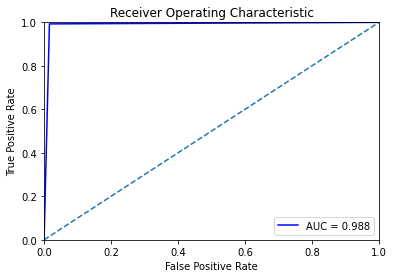

Predicted   0.0   1.0
Actual               
0.0        2091    34
1.0          29  4096
 
True Negative:  2091
False Positive:  34
False Negative:  29
True Positive:  4096
 
Accuracy: 98.99%
F1 Score: 99.24%
Precision: 99.18%
Recall: 99.30%
 
AUC: 0.988
 
Training Time: 1614.2
Testing Time: 17.3


In [0]:
from sklearn.metrics import confusion_matrix,f1_score, precision_score,recall_score,accuracy_score,roc_curve,auc,roc_auc_score

start_time = timeit.default_timer()

test_losses = []
sums = []
sizes = []

net.eval()

# Increasing threshold makes false positives more likely
threshold = 0.5

total_output = []
total_results = []
total_labels = []
for seq_tensor, seq_tensor_lengths, body_seq_tensor, body_seq_tensor_lengths, label in iter(test_loader):

    output = net(seq_tensor, seq_tensor_lengths, body_seq_tensor, body_seq_tensor_lengths).cpu().detach().numpy()
    total_output = np.hstack((total_output, output))
    result = np.round(output+(threshold-0.5), 0)

    total_results = np.hstack((total_results, result))
    total_labels = np.hstack((total_labels, label.cpu()))

    
%matplotlib inline
from sklearn.metrics import confusion_matrix,f1_score, precision_score,recall_score,accuracy_score,roc_curve,auc,roc_auc_score
auc1= roc_auc_score(total_labels, total_results)

fpr, tpr, threshold = roc_curve(total_labels, total_results,pos_label=1)
roc_auc = auc(fpr, tpr)
import matplotlib.pyplot as plt
plt.title('Receiver Operating Characteristic')
plt.plot(fpr, tpr, color = 'blue', label = 'AUC = %0.3f' % roc_auc)
plt.legend(loc = 'lower right')
plt.plot([0, 1], [0, 1],linestyle='--')
plt.xlim([0, 1])
plt.ylim([0, 1])
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.show()    
    
y_actu = pd.Series(total_labels, name='Actual')
y_pred = pd.Series(total_results, name='Predicted')
df_confusion = pd.crosstab(y_actu, y_pred)
print(df_confusion)

tn, fp, fn, tp = confusion_matrix(total_labels, total_results).ravel()

print(" ")
print("True Negative: ",tn)
print("False Positive: ",fp)
print("False Negative: ",fn)
print("True Positive: ",tp)
print(" ")
print("Accuracy: {:.2f}%".format(100 * accuracy_score(total_labels, total_results)))
print("F1 Score: {:.2f}%".format(100 * f1_score(total_labels, total_results)))
print("Precision: {:.2f}%".format(100 * precision_score(total_labels, total_results)))
print("Recall: {:.2f}%".format(100 * recall_score(total_labels, total_results)))
print(" ")
print('AUC: %.3f' % auc1)
print(" ")
print("Training Time: {:.1f}".format(training_time))
print("Testing Time: {:.1f}".format(timeit.default_timer() - start_time))

